<a href="https://colab.research.google.com/github/brianosmith/Fluoresence_data_fitting/blob/main/Fluoresence_data_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fluoresence data fitting for DAUDA binding and displacement assays

An approach to DAUDA binding and ligand displacement assays using python to achieve least squares fitting of a linear combination of the free and fully bound DAUDA spectra to spectra from a titration.

The least_sq approach is drawn from [Nicolas Coca's towardsdatascience post](https://towardsdatascience.com/classical-least-squares-method-for-quantitative-spectral-analysis-with-python-1926473a802c). The plotting with residuals is inspired by [David Pine's PyMan manual chaper 8](https://physics.nyu.edu/pine/pymanual/html/chap8/chap8_fitting.html) (see also the Gaussian fitting example below).

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec  # for unequal plot boxes
from numpy.linalg import inv
import scipy.optimize


def least_sq(sample_spectrum, components):
  # sample_spectrum (unknown spectrum): array of w values.
  # components (known spectra): array of n (number of components) columns with w values.
  # This def returns an array of n values. Each value is the similarity score for the sample_spectrum and a component spectrum.
  similarity = np.dot(inv(np.dot(components, components.T)) , np.dot(components, sample_spectrum))
  return similarity



In [52]:
#load files

from google.colab import files
uploaded = files.upload()


Saving MOPR0017.SP to MOPR0017.SP
Saving MOPR0018.SP to MOPR0018.SP
Saving MOPR0019.SP to MOPR0019.SP
Saving MOPR0020.SP to MOPR0020.SP
Saving MOPR0021.SP to MOPR0021.SP
Saving MOPR0022.SP to MOPR0022.SP
Saving MOPR0023.SP to MOPR0023.SP
Saving MOPR0024.SP to MOPR0024.SP
Saving MOPR0025.SP to MOPR0025.SP
Saving MOPR0026.SP to MOPR0026.SP
Saving MOPR0027.SP to MOPR0027.SP
Saving MOPR0028.SP to MOPR0028.SP
Saving MOPR0029.SP to MOPR0029.SP
Saving MOPR0030.SP to MOPR0030.SP
Saving MOPR0031.SP to MOPR0031.SP
Saving MOPR0032.SP to MOPR0032.SP
Saving MOPR0033.SP to MOPR0033.SP
Saving MOPR0034.SP to MOPR0034.SP
Saving MOPR0035.SP to MOPR0035.SP
Saving MOPR0036.SP to MOPR0036.SP


[0.87411805 0.34721287]


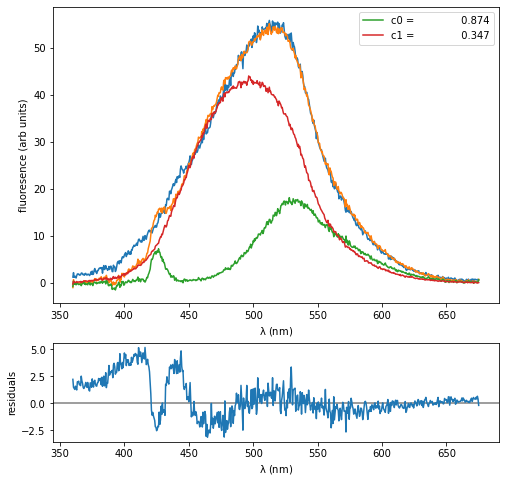

In [82]:
# read in buffer only spectrum and DAUDA in buffer data file
# l=wavelength, I=fluoresence intensity
bl, bI = np.loadtxt("MOPR0002.SP", skiprows=54, unpack=True)
sl, sI = np.loadtxt("MOPR0003.SP", skiprows=54, unpack=True)
#l = sl             # assuming that the spectra all have the same wavelengths
#subtract the baseline
iFree = np.subtract(sI, bI)
#make a smoothed version?

# read in DAUDA fully bound data file
# l=wavelength, I=fluoresence intensity
sl, sI = np.loadtxt("MOPR0016.SP", skiprows=54, unpack=True)
#l = sl
#subtract the baseline
iBound = np.subtract(sI, bI)
#need to add scaling for dilution
#make a smoothed version?

# read in spectrum from data file to be fitted
# l=wavelength, I=fluoresence intensity
sl, sI = np.loadtxt("MOPR0034.SP", skiprows=54, unpack=True)
l = sl
#subtract the baseline
iToFit = np.subtract(sI, bI)
#need to add scaling for dilution

#trim all spectra to remove most scattering affected part below 450 nm?

# make components array containing the free DAUDA and fully bound DAUDA spectra
components = np.array([iFree, iBound])

#apply least squares fit of free and bound to spectrum to be fitted
cs = least_sq(iToFit, components)

# cs contains the relative weightings of free and bound
print(cs)

# Create a figure window to plot data
fig = plt.figure(1, figsize=(8,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 2])

# Top plot: data and fit
ax1 = fig.add_subplot(gs[0])
ax1.plot(l, iToFit)
ax1.plot(l, np.dot(cs, components))

for i in np.arange(len(cs)):
    plt.plot(l, cs[i]*components[i], label = 'c' + str(i)+ ' =               ' + str(np.round(cs[i], 3)))

ax1.set_xlabel(r'$\mathregular{\lambda}$ (nm)')
ax1.set_ylabel('fluoresence (arb units)')
plt.legend()

# Bottom plot: residuals
ax2 = fig.add_subplot(gs[1])
ax2.plot(l, iToFit - np.dot(cs, components))
ax2.axhline(color="gray", zorder=-1)
ax2.set_xlabel(r'$\mathregular{\lambda}$ (nm)')
ax2.set_ylabel('residuals')

plt.show()

## Alternative approach fitting Gaussian lines
This approach is attractive, but the free and bound DAUDA emission spectra are not single Gaussians (see e.g. [Mocanu, Ionita & Matei (2020)](https://doi.org/10.1016/j.saa.2020.118413)) so probably a better approach would be to generate a synthetic spectrum from each state by fitting Gaussians and then using that in the linear combination of components approach above.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec  # for unequal plot boxes
from numpy.linalg import inv
import scipy.optimize


def Gauss(x, intensity, mu, sigma):
  # x is an array
  # mu is the expected value
  # sigma is the square root of the variance
  # intensity is a multiplication factor
  # This def returns the Gaussian function of x
  return intensity/(sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*((x-mu)/sigma)**2)

def twoGauss(x, I0, mu0, sigma0, I1, mu1, sigma1):
  # x is an array
  # Ps are intensity scaling factors
  # fps are centres
  # fws are widths (standard deviation)
  return I0/(sigma0 * np.sqrt(2*np.pi))*np.exp(-0.5*((x-mu0)/sigma0)**2) \
       + I1/(sigma1 * np.sqrt(2*np.pi))*np.exp(-0.5*((x-mu1)/sigma1)**2)


Text(0, 0.5, 'fluoresence (arb units)')

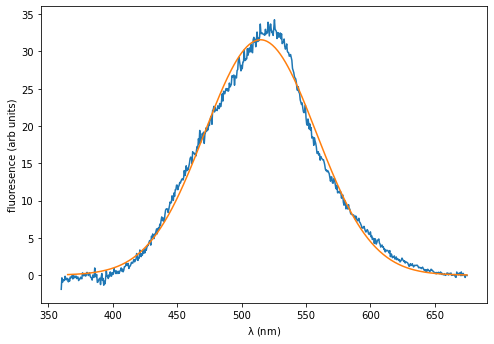

In [64]:
# read in baseline and spectrum from data file
# l=wavelength, I=fluoresence intensity
bl, bI = np.loadtxt("MOPR0002.SP", skiprows=54, unpack=True)
sl, sI = np.loadtxt("MOPR0004.SP", skiprows=54, unpack=True)
l = sl
I = np.subtract(sI, bI)


#initial guesses for fitting parameters
intensity0, mu0, sigma0 = 100., 500., 10.

# fit data using SciPy's Levenberg-Marquart method
nlfit1, nlpcov1 = scipy.optimize.curve_fit(Gauss,
                l, I, p0=[intensity0, mu0, sigma0])
#nlfit2, nlpcov2 = scipy.optimize.curve_fit(twoGauss,
#                l, I, p0=[intensity0, mu0, sigma0, intensity0, mu0, sigma0])

#unpack fitting parameters
intensityFit, muFit, sigmaFit  = nlfit1
#intensityFit1, muFit1, sigmaFit1, intensityFit2, muFit2, sigmaFit2  = nlfit2


#create fitted function
l_fit = np.linspace(365.0, 675.0, 311)
I_fit1 = Gauss(l_fit, intensityFit, muFit, sigmaFit)
#I_fit2 = twoGauss(l_fit, intensityFit1, muFit1, sigmaFit1, intensityFit2, muFit2, sigmaFit2)
#I_fit2_1 = Gauss(l_fit, intensityFit1, muFit1, sigmaFit1)
#I_fit2_2 = Gauss(l_fit, intensityFit2, muFit2, sigmaFit2)

# Create figure window to plot data
fig = plt.figure(1, figsize=(8,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 2])

# Top plot: data and fit
ax1 = fig.add_subplot(gs[0])
ax1.plot(l, I)
ax1.plot(l_fit, I_fit)
#ax1.plot(l_fit, I_fit2)
#ax1.plot(l_fit, I_fit2_1)
#ax1.plot(l_fit, I_fit2_2)
ax1.set_xlabel(r'$\mathregular{\lambda}$ (nm)')
ax1.set_ylabel('fluoresence (arb units)')
